In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import sys
from pathlib import Path

import ipywidgets as w
import ipyvuetify as v

import numpy as np
import pandas as pd
from IPython.display import display
from ipydatagrid import DataGrid


root_path = Path('/dev/projects/credit/backend/')

if (path := str(root_path.resolve())) not in sys.path:
    sys.path.append(path)

from api.data.utils import make_id, add_pcs
from api.data.fields import fields_reference, fields_yas_history
from api.data.base import tables, data_path
from api.data.processing import post_process, get_current_data
from api.gui.scatter import Scatter

In [3]:
br = tables.bonds_reference

In [4]:
from api.blp import BlpQuery
from api.data.fields import fields_reference    

In [5]:
bq = BlpQuery(timeout=50000).start()
dt_fmt = '%Y%m%d'

### Reference

In [ ]:
isins = [
    'XS2189766970',
    'USG93654AF17',
    'XS1555173019',
    'XS2062666602',
    'XS1996438948',
    'XS2010031214',
    'USG9371KAC48',
    'USG9371KAF78',
    'XS2250164964',
    'XS1573181366',
    'XS2187646901',
    'USG9434GAA25',
    'XS2231188876',
    'XS2231189924',
    'XS2358483258',
    'USG9444PAD45',
    'USG9444PAA06',
    'XS1642682410',
    'XS1642686676',
    'XS2361253607',
    'XS1684384867',
    'XS2361252971',
    'XS1684384511',
    'XS2361253433',
    'XS1684385161',
    'XS1266660122',
    'XS1793255941',
    'XS2362416617',
    'XS2361253862',
    'XS1684385591',
    'XS2361255057',
    'XS2361254597',
    'XS1793255198',
    'XS1811213781',
    'XS2362416294',
    'XS1811213435',
    'XS1266660635',
    'XS1266662334',
    'XS1266661013',
    'XS1811212890',
    'XS1811213864',
]

In [ ]:
securities = make_id(isins, 'isin')

res = bq.bdp(
    securities=securities,
    fields=[field['field'] for field in fields_reference],
)

ref = post_process(res)
ref.to_csv(data_path / 'basil_reference.csv', index=False)

### History

In [ ]:
bonds_ref = ref

end_date = pd.Timestamp.today().floor('D')
start_date = end_date - pd.tseries.offsets.DateOffset(months=6)

data_limit = 50000
securities = None  # securities = bonds_ref['security'].drop_duplicates().to_list()
fields = [field['field'] for field in fields_yas_history]

if securities is not None:
    subset = bonds_ref.loc[bonds_ref['security'].isin(securities)]
else:
    subset = bonds_ref

start_date_ = max(start_date, subset['issue_date'].min())
date_range = pd.date_range(start=start_date_, end=end_date, freq='B')

In [ ]:
res = {}
i = 0

for date in date_range[2:]:
    subset_ = subset.loc[(bonds_ref['issue_date'] <= date)]
    if not subset_.empty:
        i += len(subset_) * len(fields)
        print(f'at {date} {i} data points downloaded, limit is {data_limit}')
        
        res_ = []
        
        for field in fields_yas_history:
            while True:
                try:
                    res__ = bq.bdp(
                        securities=subset_['security'].to_list(),
                        fields=[field['field']],
                        overrides=[
                            ('USER_LOCAL_TRADE_DATE', date.strftime(dt_fmt)),
                            *field.get('overrides', [])
                        ]
                    )
                except ConnectionError:
                    print('retrying for date {date} because of connection timeout')
                else:
                    res_.append(res__.set_index('security'))
                    break
        res_ = pd.concat(res_, axis=1)
                    
        res[date] = res_
    if data_limit and i >= data_limit:
        print(f'at date {date} data limit reached')
        break
        
res = pd.concat(res)
res = res.rename_axis(['date', 'security']).rename({field['field']: field['name'] for field in fields_yas_history}, axis=1)
res.to_csv(data_path / 'basil_history.csv')

### GUI

In [6]:
from api.data.base import date_columns
ref = pd.read_csv(data_path / 'basil_reference.csv', parse_dates=date_columns, dayfirst=True)
mkt = pd.read_csv(data_path / 'basil_history.csv', parse_dates=['date'], dayfirst=True)

In [7]:
current_data = get_current_data(ref_data=ref.set_index('security'), mkt_data=mkt.set_index(['date', 'security']).loc[mkt['date'].max()])
current_data['rating_bucket'] = current_data['rating_bucket'].fillna('NA')

In [10]:
sc = Scatter(data=current_data, y_items=['z_spread', 'z_spread_xccy_usd', 'z_spread_basis'])

In [11]:
sc

In [41]:
ref.sort_values('ticker')

security  ticker                   name          isin currency  \
0   /isin/XS1811213864  SOFTBK  SOFTBK 4 1/2 04/20/25  XS1811213864      EUR   
30  /isin/XS2361253607  SOFTBK  SOFTBK 5 1/4 07/06/31  XS2361253607      USD   
29  /isin/XS1642686676  SOFTBK      SOFTBK 6 7/8 PERP  XS1642686676      USD   
28  /isin/XS1642682410  SOFTBK          SOFTBK 6 PERP  XS1642682410      USD   
19  /isin/XS1266661013  SOFTBK  SOFTBK 5 1/4 07/30/27  XS1266661013      EUR   
18  /isin/XS1266662334  SOFTBK  SOFTBK 4 3/4 07/30/25  XS1266662334      EUR   
17  /isin/XS1266660635  SOFTBK  SOFTBK 5 3/8 07/30/22  XS1266660635      USD   
16  /isin/XS1811213435  SOFTBK  SOFTBK 6 1/8 04/20/25  XS1811213435      USD   
15  /isin/XS2362416294  SOFTBK  SOFTBK 3 1/8 01/06/25  XS2362416294      USD   
14  /isin/XS1811213781  SOFTBK      SOFTBK 4 04/20/23  XS1811213781      EUR   
13  /isin/XS1793255198  SOFTBK  SOFTBK 6 1/4 04/15/28  XS1793255198      USD   
12  /isin/XS2361254597  SOFTBK  SOFTBK 2 7/8 01/06/27  XS2361254597      EUR   
20  /isin/XS1811212890  SOFTBK  SOFTBK 5 1/2 04/20/23  XS1811212890      USD   
10  /isin/XS1684385591  SOFTBK      SOFTBK 4 09/19/29  XS1684385591      EUR   
3   /isin/XS1684384511  SOFTBK  SOFTBK 4 3/4 09/19/24  XS1684384511      USD   
11  /isin/XS2361255057  SOFTBK  SOFTBK 3 3/8 07/06/29  XS2361255057      EUR   
2   /isin/XS2361252971  SOFTBK      SOFTBK 4 07/06/26  XS2361252971      USD   
4   /isin/XS2361253433  SOFTBK  SOFTBK 4 5/8 07/06/28  XS2361253433      USD   
1   /isin/XS1684384867  SOFTBK  SOFTBK 5 1/8 09/19/27  XS1684384867      USD   
6   /isin/XS1266660122  SOFTBK      SOFTBK 6 07/30/25  XS1266660122      USD   
7   /isin/XS1793255941  SOFTBK      SOFTBK 5 04/15/28  XS1793255941      EUR   
8   /isin/XS2362416617  SOFTBK  SOFTBK 3 7/8 07/06/32  XS2362416617      EUR   
9   /isin/XS2361253862  SOFTBK  SOFTBK 2 1/8 07/06/24  XS2361253862      EUR   
5   /isin/XS1684385161  SOFTBK  SOFTBK 3 1/8 09/19/25  XS1684385161      EUR   
38  /isin/USG9371KAF78    VMED    VMED 4 1/2 08/15/30  USG9371KAF78      USD   
36  /isin/XS2010031214    VMED    VMED 4 1/8 08/15/30  XS2010031214      GBP   
35  /isin/XS1996438948    VMED    VMED 5 1/4 05/15/29  XS1996438948      GBP   
34  /isin/XS2062666602    VMED    VMED 4 1/4 01/15/30  XS2062666602      GBP   
33  /isin/XS1555173019    VMED        VMED 5 04/15/27  XS1555173019      GBP   
32  /isin/USG93654AF17    VMED        VMED 5 07/15/30  USG93654AF17      USD   
37  /isin/USG9371KAC48    VMED    VMED 5 1/2 05/15/29  USG9371KAC48      USD   
26  /isin/USG9444PAD45    VMED    VMED 4 3/4 07/15/31  USG9444PAD45      USD   
27  /isin/USG9444PAA06    VMED    VMED 4 1/4 01/31/31  USG9444PAA06      USD   
25  /isin/XS2358483258    VMED    VMED 4 1/2 07/15/31  XS2358483258      GBP   
24  /isin/XS2231189924    VMED        VMED 4 01/31/29  XS2231189924      GBP   
23  /isin/XS2231188876    VMED    VMED 3 1/4 01/31/31  XS2231188876      EUR   
22  /isin/USG9434GAA25    VMED        VMED 5 07/15/28  USG9434GAA25      USD   
21  /isin/XS2187646901    VMED    VMED 4 7/8 07/15/28  XS2187646901      GBP   
39  /isin/XS2250164964    VMED    VMED 4 1/8 08/15/30  XS2250164964      GBP   
31  /isin/XS2189766970    VMED    VMED 3 3/4 07/15/30  XS2189766970      EUR   
40  /isin/XS1573181366    VMED        VMED 6 01/15/25  XS1573181366      GBP   

   country     bics_sector                         bics_industry  \
0       JP  Communications  Wireless Telecommunications Services   
30      JP  Communications  Wireless Telecommunications Services   
29      JP  Communications  Wireless Telecommunications Services   
28      JP  Communications  Wireless Telecommunications Services   
19      JP  Communications  Wireless Telecommunications Services   
18      JP  Communications  Wireless Telecommunications Services   
17      JP  Communications  Wireless Telecommunications Services   
16      JP  Communications  Wireless Telecommunications Services   
15      JP  Communications  Wireless Tele

In [42]:
isn = [
    '/isin/XS2187646901',
    '/isin/XS2189766970'
]

In [53]:
isn = ref.query(f"ticker == 'VMED'")['security'].to_list()

In [55]:
d = mkt.query(f'security in {isn}')

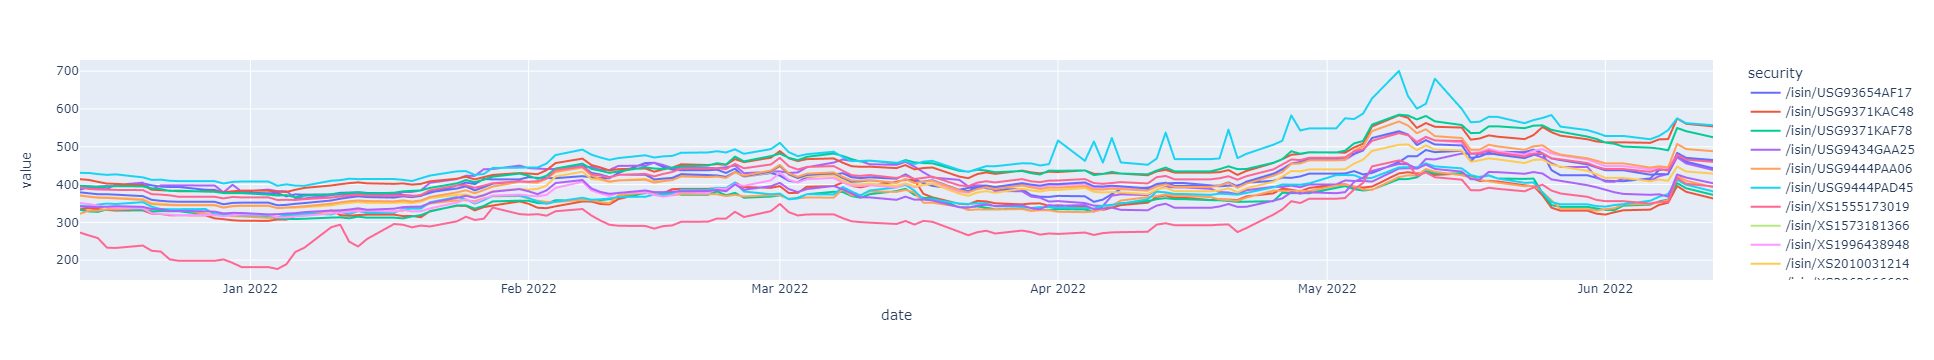

In [56]:
d.pivot(index='date', columns='security', values='z_spread_xccy_usd').ffill().plot(backend='plotly')

In [16]:
ticker = 'VMED' 
col = current_data.query(f'ticker == "{ticker}"')['z_spread_xccy_usd']

In [30]:
m_ = col.to_frame().to_numpy() / col.to_frame().to_numpy().T
m = pd.DataFrame(m_, index=col.index, columns=col.index)

In [ ]:
m_[np.tril_indices(len(m_))] = np.triu(m_)

In [18]:
from plotly import graph_objects as go
from plotly import figure_factory as ff

In [ ]:
m = seriate(m, 'euclidean')

In [28]:
f = ff.create_annotated_heatmap(
    z=m.round(3).to_numpy(),
    x=[*m.index],
    y=[*m.index],
    colorscale='RdBu',
    zmid=1
)

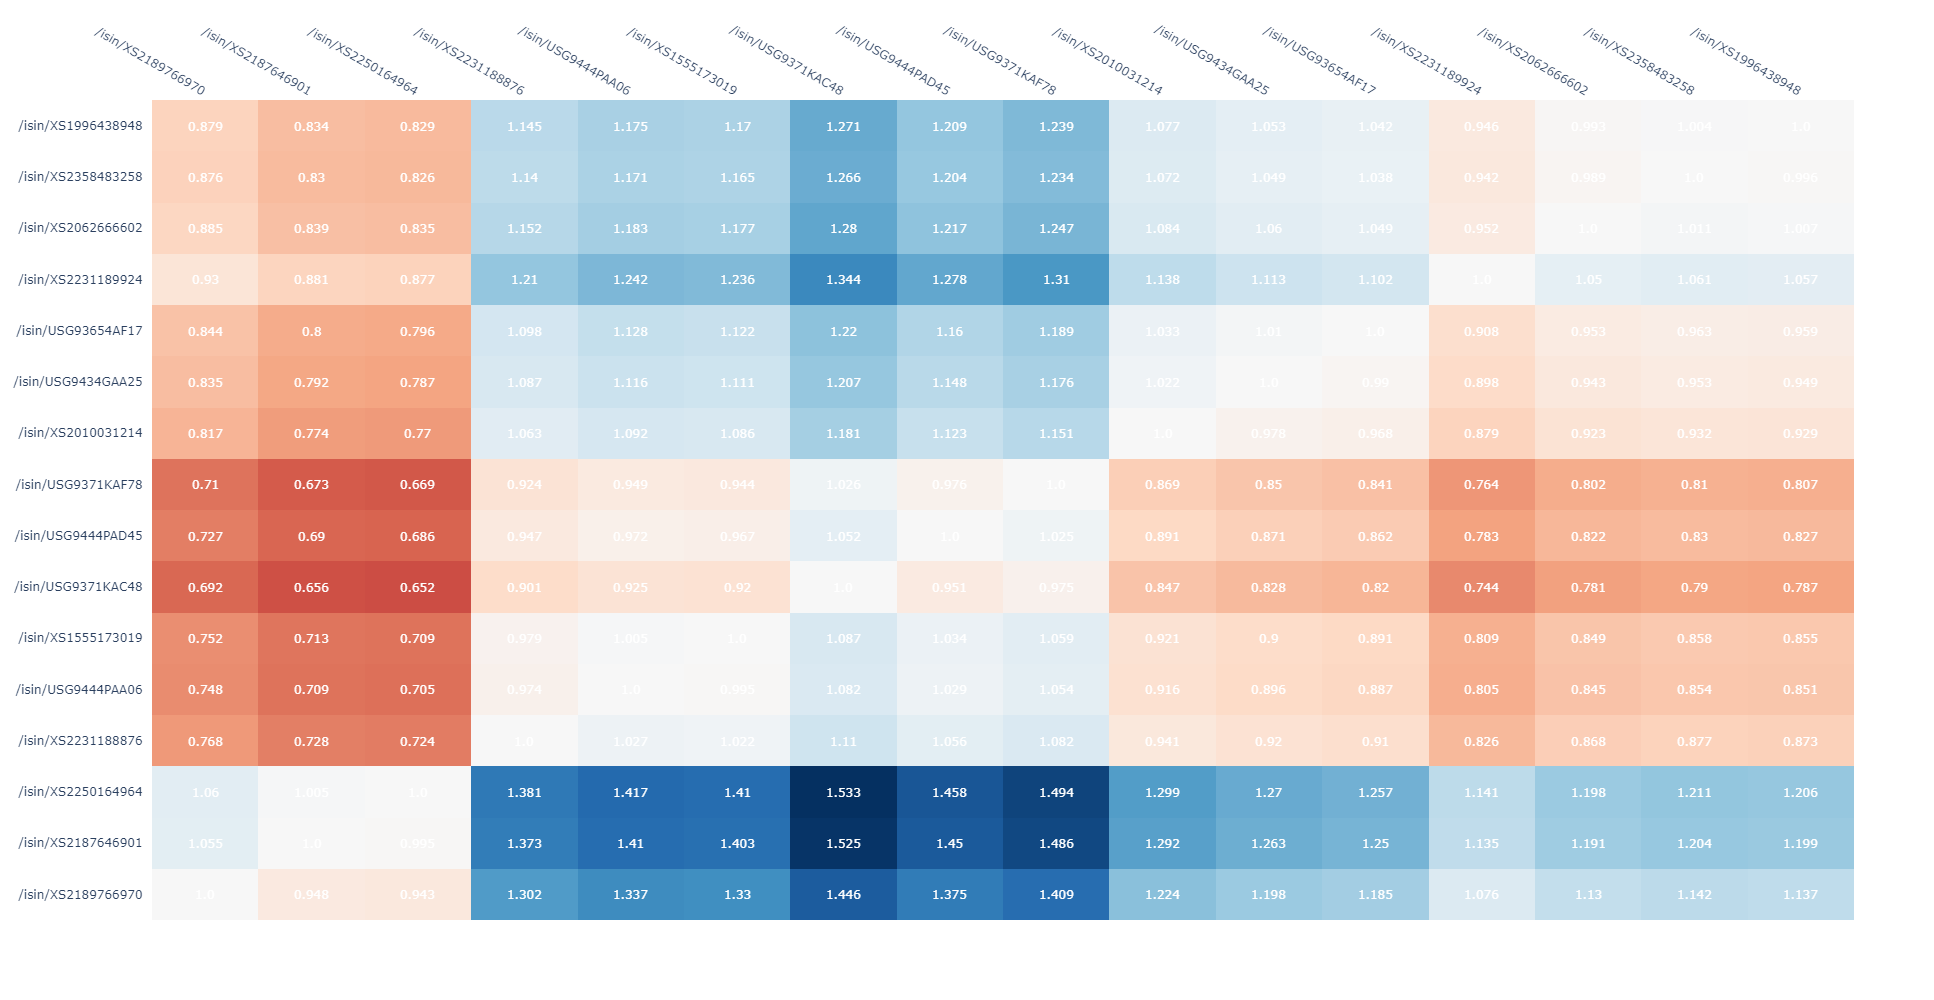

In [29]:
f.update_layout(
    height=1000
)

In [ ]:
current_data.groupby(['maturity_bucket', 'rating_bucket'])['z_spread_xccy_usd'].mean()

In [22]:
from itertools import chain
from io import StringIO

import ipywidgets as w
import numpy as np
import pandas as pd
import requests
from plotly import (
    io as pio,
    express as px,
    graph_objects as go,
    figure_factory as ff
)
from plotly.subplots import make_subplots
from scipy.linalg import block_diag
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import (
    linkage,
    fcluster,
    optimal_leaf_ordering,
    leaves_list,
    dendrogram
)

class DFPlot:
    def __init__(self, df):
        self.df = df
        self.dd = w.Dropdown(options=df.columns)

        def fn(col):
            fig = self.df[col].plot(backend='plotly')
            display(fig)


        self.out = w.interactive_output(fn, dict(col=self.dd))
        self.app = w.VBox([self.dd, self.out])

    def _ipython_display_(self):
        return display(self.app)


def corr_plot(
    corr,
    title=None,
    fmt='.0%',
    width=None,
    height=None,
    colorscale=None,
    showscale=True,
    **kwargs,
):
    if fmt:
        fig = ff.create_annotated_heatmap(
            z=corr.to_numpy(),
            x=[*corr.columns],
            y=[*corr.index],
            annotation_text=corr.applymap(lambda x: f'{x: {fmt}}').to_numpy(),
            colorscale=colorscale or 'viridis',
            showscale=showscale,
            **kwargs
        )
    else:
        fig = go.Figure(
            data=go.Heatmap(
                z=corr.to_numpy(),
                x=[*corr.columns],
                y=[*corr.index],
                colorscale=colorscale or 'viridis',
                showscale=showscale,
                **kwargs
            )
        )


    # fig.update_xaxes(tickangle=45, side='bottom')

    fig.update_layout(
        autosize=False,
        title={
            'text': title,
            'y':0.9,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'
        } if title else None,
        width=width or 1000,
        height=height or 700
    )\
       .update_xaxes(tickangle=45, side='bottom')

    return fig


def agg_ret(prices, freq='A', compounded=False):
    to_freq = prices.resample(freq).last()

    res = pd.concat([
        pd.Series(prices.iloc[0], index=[prices.index[0] - pd.tseries.frequencies.to_offset(freq)]),
        to_freq
    ])

    if compounded:
        res = res.pct_change().dropna()
    else:
        res = res.diff().dropna()

    if freq=='M':
        res = pd.concat(
            [pd.Series(group.to_numpy(), index=group.index.month, name=group.index[0].year) for index, group in res.groupby(pd.Grouper(freq='A'))],
            axis=1
        )

    return res


@pd.api.extensions.register_dataframe_accessor("zscore")
class ZScore:
    def __init__(self, pandas_obj):
        self._obj = pandas_obj

    def __call__(self, n):
        obj = self._obj
        rolling = obj.rolling(n)
        return (obj - rolling.mean()) / rolling.std()

    
@pd.api.extensions.register_series_accessor("zscore")
class ZScore:
    def __init__(self, pandas_obj):
        self._obj = pandas_obj

    def __call__(self, n):
        obj = self._obj
        rolling = obj.rolling(n)
        return (obj - rolling.mean()) / rolling.std()


def distance_correlation(corr):
    return ((1 - corr) / 2) ** 0.5


def seriate(corr, dist=None):
    if not dist:
        dist_corr = distance_correlation(corr)
    else:
        dist_corr = pdist(corr, metric=dist)
    flat_dist = squareform(dist_corr)
    # dim = len(dist_corr)
    # tri_a, tri_b = np.triu_indices(dim, k=1)
    # flat_dist = dist_corr[tri_a, tri_b]  # this is same as squareform(dist_corr)

    Z = linkage(flat_dist, method='ward')
    order = leaves_list(Z)
    return corr.iloc[order, order]




C:\Users\gperciaccante\AppData\Local\Temp\1\ipykernel_4268\2971750067.py:117: UserWarning:

registration of accessor <class '__main__.ZScore'> under name 'zscore' for type <class 'pandas.core.frame.DataFrame'> is overriding a preexisting attribute with the same name.

C:\Users\gperciaccante\AppData\Local\Temp\1\ipykernel_4268\2971750067.py:128: UserWarning:

registration of accessor <class '__main__.ZScore'> under name 'zscore' for type <class 'pandas.core.series.Series'> is overriding a preexisting attribute with the same name.



In [26]:
seriate(m, 'euclidean')

C:\Users\gperciaccante\AppData\Local\Temp\1\ipykernel_4268\2971750067.py:152: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



security            /isin/XS2189766970  /isin/XS2187646901  \
security                                                     
/isin/XS2189766970            1.000000            0.948092   
/isin/XS2187646901            1.054750            1.000000   
/isin/XS2250164964            1.060449            1.005402   
/isin/XS2231188876            0.768108            0.728236   
/isin/USG9444PAA06            0.748143            0.709308   
/isin/XS1555173019            0.751877            0.712848   
/isin/USG9371KAC48            0.691735            0.655828   
/isin/USG9444PAD45            0.727397            0.689639   
/isin/USG9371KAF78            0.709723            0.672883   
/isin/XS2010031214            0.816665            0.774274   
/isin/USG9434GAA25            0.834983            0.791640   
/isin/USG93654AF17            0.843741            0.799943   
/isin/XS2231189924            0.929544            0.881292   
/isin/XS2062666602            0.885229            0.839279   
/isin/XS2358483258            0.875864            0.830399   
/isin/XS1996438948            0.879421            0.833772   

security            /isin/XS2250164964  /isin/XS2231188876  \
security                                                     
/isin/XS2189766970            0.942997            1.301901   
/isin/XS2187646901            0.994627            1.373181   
/isin/XS2250164964            1.000000            1.380599   
/isin/XS2231188876            0.724323            1.000000   
/isin/USG9444PAA06            0.705497            0.974008   
/isin/XS1555173019            0.709018            0.978869   
/isin/USG9371KAC48            0.652304            0.900570   
/isin/USG9444PAD45            0.685933            0.946999   
/isin/USG9371KAF78            0.669267            0.923989   
/isin/XS2010031214            0.770113            1.063218   
/isin/USG9434GAA25            0.787387            1.087065   
/isin/USG93654AF17            0.795645            1.098467   
/isin/XS2231189924            0.876557            1.210174   
/isin/XS2062666602            0.834769            1.152481   
/isin/XS2358483258            0.825937            1.140288   
/isin/XS1996438948            0.829291            1.144919   

security            /isin/USG9444PAA06  /isin/XS1555173019  \
security                                                     
/isin/XS2189766970            1.336643            1.330005   
/isin/XS2187646901            1.409825            1.402824   
/isin/XS2250164964            1.417441            1.410402   
/isin/XS2231188876            1.026685            1.021587   
/isin/USG9444PAA06            1.000000            0.995034   
/isin/XS1555173019            1.004991            1.000000   
/isin/USG9371KAC48            0.924602            0.920011   
/isin/USG9444PAD45            0.972270            0.967442   
/isin/USG9371KAF78            0.948647            0.943936   
/isin/XS2010031214            1.091590            1.086169   
/isin/USG9434GAA25            1.116074            1.110532   
/isin/USG93654AF17            1.127780            1.122179   
/isin/XS2231189924            1.242468            1.236298   
/isin/XS2062666602            1.183236            1.177360   
/isin/XS2358483258            1.170718            1.164904   
/isin/XS1996438948            1.175472            1.169634   

security            /isin/USG9371KAC48  /isin/USG9444PAD45  \
security                                                     
/isin/XS2189766970            1.445641            1.374765   
/isin/XS2187646901            1.524791            1.450034   
/isin/XS2250164964            1.533028            1.457868   
/isin/XS2231188876            1.110408            1.055968   
/isin/USG9444PAA06            1.081546            1.028521   
/isin/XS1555173019            1.086944            1.033654   
/isin/USG9371KAC48            1.000000            0.950973   
/isin/USG9444PAD45            1.051555            1.000000   
/isin/USG9371KAF78           

In [24]:
m

security            /isin/XS2187646901  /isin/USG9434GAA25  \
security                                                     
/isin/XS2187646901            1.000000            1.263200   
/isin/USG9434GAA25            0.791640            1.000000   
/isin/XS2231188876            0.728236            0.919908   
/isin/XS2231189924            0.881292            1.113248   
/isin/XS2358483258            0.830399            1.048960   
/isin/USG9444PAD45            0.689639            0.871152   
/isin/USG9444PAA06            0.709308            0.895998   
/isin/XS2189766970            0.948092            1.197629   
/isin/USG93654AF17            0.799943            1.010488   
/isin/XS1555173019            0.712848            0.900469   
/isin/XS2062666602            0.839279            1.060176   
/isin/XS1996438948            0.833772            1.053220   
/isin/XS2010031214            0.774274            0.978062   
/isin/USG9371KAC48            0.655828            0.828442   
/isin/USG9371KAF78            0.672883            0.849985   
/isin/XS2250164964            1.005402            1.270024   

security            /isin/XS2231188876  /isin/XS2231189924  \
security                                                     
/isin/XS2187646901            1.373181            1.134697   
/isin/USG9434GAA25            1.087065            0.898272   
/isin/XS2231188876            1.000000            0.826328   
/isin/XS2231189924            1.210174            1.000000   
/isin/XS2358483258            1.140288            0.942252   
/isin/USG9444PAD45            0.946999            0.782531   
/isin/USG9444PAA06            0.974008            0.804850   
/isin/XS2189766970            1.301901            1.075797   
/isin/USG93654AF17            1.098467            0.907693   
/isin/XS1555173019            0.978869            0.808867   
/isin/XS2062666602            1.152481            0.952327   
/isin/XS1996438948            1.144919            0.946078   
/isin/XS2010031214            1.063218            0.878566   
/isin/USG9371KAC48            0.900570            0.744166   
/isin/USG9371KAF78            0.923989            0.763518   
/isin/XS2250164964            1.380599            1.140827   

security            /isin/XS2358483258  /isin/USG9444PAD45  \
security                                                     
/isin/XS2187646901            1.204240            1.450034   
/isin/USG9434GAA25            0.953325            1.147906   
/isin/XS2231188876            0.876971            1.055968   
/isin/XS2231189924            1.061287            1.277904   
/isin/XS2358483258            1.000000            1.204107   
/isin/USG9444PAD45            0.830491            1.000000   
/isin/USG9444PAA06            0.854177            1.028521   
/isin/XS2189766970            1.141730            1.374765   
/isin/USG93654AF17            0.963324            1.159945   
/isin/XS1555173019            0.858440            1.033654   
/isin/XS2062666602            1.010693            1.216983   
/isin/XS1996438948            1.004061            1.208997   
/isin/XS2010031214            0.932411            1.122723   
/isin/USG9371KAC48            0.789774            0.950973   
/isin/USG9371KAF78            0.810312            0.975703   
/isin/XS2250164964            1.210746            1.457868   

security            /isin/USG9444PAA06  /isin/XS2189766970  \
security                                                     
/isin/XS2187646901            1.409825            1.054750   
/isin/USG9434GAA25            1.116074            0.834983   
/isin/XS2231188876            1.026685            0.768108   
/isin/XS2231189924            1.242468            0.929544   
/isin/XS2358483258            1.170718            0.875864   
/isin/USG9444PAD45            0.972270            0.727397   
/isin/USG9444PAA06            1.000000            0.748143   
/isin/XS2189766970            1.336643            1.000000   
/isin/USG93654AF17           